![](https://img.shields.io/badge/PO.DAAC-Contribution-%20?color=grey&labelColor=blue)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/GIS/SWOTshp_CSVconversion.ipynb).

_Note: This notebook uses Version C (2.0) of SWOT data that was available at the time of this notebook's development. The most recent data is now available as Version D for SWOT collections._
_The last Version C measurement will be until May 3rd, 2025. The first Version D measurement starts on May 5th, 2025._

# SWOT Shapefile Data Conversion to CSV

### Notebook showcasing how to merge/concatenate multiple lake shapefiles into a single file.
- Utilizing the merged shapefile and converting it to a csv file.
- Option to query the new dataset based on users choice; either 'lake_id' or water surface elevation ('wse'), etc.
- Using the queried variable to export it as a csv or shapefile.

**Note, PO.DAAC will be expanding the [Hydrocron API](https://podaac.github.io/hydrocron/intro.html) we built for rivers to include lakes, but as of this moment, here is a work around to produce lake time series from shapefiles!**

_Authors: Nicholas Tarpinian, Cassie Nickles, NASA PO.DAAC_

### Import libraries

In [19]:
import geopandas as gpd
import glob
from pathlib import Path
import pandas as pd
import os
import zipfile
import earthaccess
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None) #all columns displayed default

## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login, which is required to access data from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register for an Earthdata Login account. It is free to create and only takes a moment to set up.

In [4]:
auth = earthaccess.login() 

### Search for SWOT data
Let's start our search for Lake Vector Shapefiles in North America. SWOT files come in "Prior", "Obs" or "Unassigned" versions in the same collection, here we want the Prior Lakes from the Prior Lake Database. We will also only get files for North America, or 'NA' and can call out a specific pass number that we want. Each dataset has it's own shortname associate with it, for the SWOT Lake shapefiles, it is SWOT_L2_HR_LakeSP_2.0.

Let's say we are interested in a lake that has SWOT passes numbered 188 and 259. (These SWOT passes were identified for this region using the [.kmz file](https://podaac.github.io/tutorials/quarto_text/SWOT.html#swot-spatial-coverage) of SWOT passes/swaths imported into Google Earth Pro for visualization.)

In [8]:
# Enter pass number(s)
pass_number    = ["188", "259"]   

# Enter continent code
continent_code = "NA"     # e.g. "AF", "NA", "EU", "SI", "AS", "AU", "SA", "AR", "GR"

# Retrieves granulev and links list from the passes we want, in this case by passing to `earthdata.search_data` function the data collection shortname and temporal bounds
links_list = []
for p in range(len(pass_number)):
    lake_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_LAKESP_2.0', 
                                        temporal = ('2023-07-01 00:00:00', '2024-07-24 23:59:59'),
                                        granule_name = "*Prior*_" + pass_number[p] + "_" + continent_code + "*")
    for r in range(len(lake_results)):
        lake_link = earthaccess.results.DataGranule.data_links(lake_results[r], access='external')[0]
        links_list.append(lake_link)

Granules found: 20
Granules found: 19


The SWOT orbit cycle is 21 days, these numbers make sense for the time range selected.

### Download the Data into a folder

In [9]:
earthaccess.download(links_list, "../datasets/data_downloads/SWOT_files/")
folder = Path("../datasets/data_downloads/SWOT_files")

QUEUEING TASKS | :   0%|          | 0/39 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/39 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/39 [00:00<?, ?it/s]

### Unzip shapefiles in existing folder

In [10]:
for item in os.listdir(folder): # loop through items in dir
    if item.endswith(".zip"): # check for ".zip" extension
        zip_ref = zipfile.ZipFile(f"{folder}/{item}") # create zipfile object
        zip_ref.extractall(folder) # extract file to dir
        zip_ref.close() # close file

### Opening multiple shapefiles from within a folder
Lets open all the shapefiles we've downloaded together into one database. This approach is ideal for a small number of granules, but if you're looking to create large timeseries, consider using the PO.DAAC Hydrocron tool that will be available for lakes ~Sept 2024.

In [14]:
filenames = []
for l in range(len(links_list)):
    filenames.append(links_list[l].split("/")[-1])
    
# replace zip file names with .shp ending
filename_shps = [filename.replace('zip', 'shp') for filename in filenames]

#initialize opened list of files
SWOT_HR_shps = []

# Loop through queried granules to open and stack all acquisition dates
for j in range(len(filename_shps)):
    SWOT_HR_shps.append(gpd.read_file(f'../datasets/data_downloads/SWOT_files/{filename_shps[j]}'))  

In [15]:
# Combine granules from all acquisition dates into one dataframe
SWOT_HR_df = gpd.GeoDataFrame(pd.concat(SWOT_HR_shps, ignore_index=True))

# Sort dataframe by lake_id and time
SWOT_HR_df = SWOT_HR_df.sort_values(['lake_id', 'time'])

SWOT_HR_df

,lake_id,reach_id,obs_id,overlap,n_overlap,time,time_tai,time_str,wse,wse_u,wse_r_u,wse_std,area_total,area_tot_u,area_detct,area_det_u,layovr_val,xtrk_dist,ds1_l,ds1_l_u,ds1_q,ds1_q_u,ds2_l,ds2_l_u,ds2_q,ds2_q_u,quality_f,dark_frac,ice_clim_f,ice_dyn_f,partial_f,xovr_cal_q,geoid_hght,solid_tide,load_tidef,load_tideg,pole_tide,dry_trop_c,wet_trop_c,iono_c,xovr_cal_c,lake_name,p_res_id,p_lon,p_lat,p_ref_wse,p_ref_area,p_date_t0,p_ds_t0,p_storage,geometry
0,7110570263,71181400383;71181301143;71181400253;7118140019...,no_data,no_data,no_data,-1.000000e+12,-1.000000e+12,no_data,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-999,-1.000000e+12,0,-999,-999,-999,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,NOTIGI RESERVOIR;GRANVILLE;SUWANNEE RIVER;RIVI...,702,-99.127615,56.877484,-1.000000e+12,3659.707925,no_data,-1.000000e+12,-1.000000e+12,None
75228,7110570263,71181400383;71181301143;71181400253;7118140019...,no_data,no_data,no_data,-1.000000e+12,-1.000000e+12,no_data,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-999,-1.000000e+12,0,-999,-999,-999,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,NOTIGI RESERVOIR;GRANVILLE;SUWANNEE RIVER;RIVI...,702,-99.127615,56.877484,-1.000000e+12,3659.707925,no_data,-1.000000e+12,-1.000000e+12,None
171841,7110570263,71181400383;71181301143;71181400253;7118140019...,no_data,no_data,no_data,-1.000000e+12,-1.000000e+12,no_data,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-999,-1.000000e+12,0,-999,-999,-999,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,NOTIGI RESERVOIR;GRANVILLE;SUWANNEE RIVER;RIVI...,702,-99.127615,56.877484,-1.000000e+12,3659.707925,no_data,-1.000000e+12,-1.000000e+12,None
259953,7110570263,71181400383;71181301143;71181400253;7118140019...,no_data,no_data,no_data,-1.000000e+12,-1.000000e+12,no_data,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-999,-1.000000e+12,1,-999,-999,-999,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,NOTIGI RESERVOIR;GRANVILLE;SUWANNEE RIVER;RIVI...,702,-99.127615,56.877484,-1.000000e+12,3659.707925,no_data,-1.000000e+12,-1.000000e+12,None
322528,7110570263,71181400383;71181301143;71181400253;7118140019...,no_data,no_data,no_data,-1.000000e+12,-1.000000e+12,no_data,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-999,-1.000000e+12,2,-999,-999,-999,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,NOTIGI RESERVOIR;GRANVILLE;SUWANNEE RIVER;RIVI...,702,-99.127615,56.877484,-1.000000e+12,3659.707925,no_data,-1.000000e+12,-1.000000e+12,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Querying a Shapefile

Let's get the attributes from a particular reach of the merged shapefile. If you want to search for a specific lake_id, Lake IDs can be identified in the [Prior Lake Database (PLD)](https://hydroweb.next.theia-land.fr/) - Add in the PLD layer into Hydroweb.next to see the lakes SWOT products are based upon.

In [16]:
lake = SWOT_HR_df.query("lake_id == '7421108633'") #Willow Reservoir, WI

# Remove fill values for missing observations
lake = lake.loc[(lake["wse"] != -999999999999.0)]
# Convert time_str to datetime format
lake.time_str = pd.to_datetime(lake.time_str)

lake

,lake_id,reach_id,obs_id,overlap,n_overlap,time,time_tai,time_str,wse,wse_u,wse_r_u,wse_std,area_total,area_tot_u,area_detct,area_det_u,layovr_val,xtrk_dist,ds1_l,ds1_l_u,ds1_q,ds1_q_u,ds2_l,ds2_l_u,ds2_q,ds2_q_u,quality_f,dark_frac,ice_clim_f,ice_dyn_f,partial_f,xovr_cal_q,geoid_hght,solid_tide,load_tidef,load_tideg,pole_tide,dry_trop_c,wet_trop_c,iono_c,xovr_cal_c,lake_name,p_res_id,p_lon,p_lat,p_ref_wse,p_ref_area,p_date_t0,p_ds_t0,p_storage,geometry
70153,7421108633,no_data,742074L000285;742074L000379,91;0,2,7.438108e+08,7.438108e+08,2023-07-27 22:06:40+00:00,463.611,0.002,0.001,0.108,20.476219,0.036599,20.372474,0.036599,0.013,-19436.229,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,1,0.005067,0,-999,1,1,-31.098343,-0.075313,-0.006001,-0.006082,-0.002511,-2.186316,-0.264965,-0.005642,-3.498030e-01,WILLOW RESERVOIR;WILLOW FLOWAGE,1453,-89.882334,45.719562,-1.000000e+12,21.401108,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((-89.93124 45.72805, -89.93171 ..."
1538047,7421108633,no_data,742235R000207;742235R000203;742235R000208;7422...,53;2;15;1;1;1;1;1;1;0;0;0;0;0;0;0;0;0;0;0,20,7.440316e+08,7.440316e+08,2023-07-30 11:26:18+00:00,463.547,0.007,0.002,0.118,17.682375,0.031983,15.923572,0.031983,0.013,17795.550,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,0,0.099466,0,-999,1,0,-31.102056,-0.013887,0.008220,0.007828,-0.002397,-2.200979,-0.099860,-0.003437,3.984390e-01,WILLOW RESERVOIR;WILLOW FLOWAGE,1453,-89.882334,45.719562,-1.000000e+12,21.401108,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((-89.88040 45.69027, -89.88045 ..."
144201,7421108633,no_data,742074L000521;742074L000520;742074L000636,86;0;0,3,7.474162e+08,7.474162e+08,2023-09-07 15:36:52+00:00,462.473,0.004,0.002,0.156,18.984428,0.035149,18.547000,0.035149,0.018,-19801.049,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,0,0.023041,0,-999,0,0,-31.100694,0.097939,0.000264,0.000239,0.000261,-2.192609,-0.142751,-0.006593,-3.143100e-02,WILLOW RESERVOIR;WILLOW FLOWAGE,1453,-89.882334,45.719562,-1.000000e+12,21.401108,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((-89.89536 45.75987, -89.89574 ..."
1586938,7421108633,no_data,742235R000202;742235R000209;742235R000224;7422...,77;5;0;0;0;0,6,7.476370e+08,7.476370e+08,2023-09-10 04:56:30+00:00,462.438,0.004,0.002,0.182,18.651090,0.034293,17.137234,0.034293,0.014,17938.629,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,0,0.081167,0,-999,0,0,-31.100028,-0.039234,-0.003683,-0.003884,0.000462,-2.202635,-0.189953,-0.002911,2.005800e-02,WILLOW RESERVOIR;WILLOW FLOWAGE,1453,-89.882334,45.719562,-1.000000e+12,21.401108,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((-89.88855 45.72574, -89.88860 ..."
221751,7421108633,no_data,742074L000253;742074L000289;742074L000263;7420...,75;5;0;0;0;0;0,7,7.492189e+08,7.492190e+08,2023-09-28 12:21:55+00:00,462.592,0.005,0.002,0.201,18.143098,0.028457,13.775469,0.028457,0.010,-19711.129,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,0,0.240732,0,-999,1,0,-31.102144,-0.129188,-0.001035,-0.001172,0.002102,-2.202799,-0.144220,-0.003619,9.756520e-01,WILLOW RESERVOIR;WILLOW FLOWAGE,1453,-89.882334,45.719562,-1.000000e+12,21.401108,no_data,-1.000000e+12,-1.000000e+12,"MULTIPOLYGON (((-89.89708 45.75170, -89.89747 ..."
1640305,7421108633,no_data,742235R000221;742235R000224;742235R000240;7422...,75;5;0;0;0,5,7.494397e+08,7.494397e+08,2023-10-01 01:41:32+00:00,462.645,0.008,0.002,0.215,18.544291,0.029883,12.616708,0.029883,0.015,17090.920,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,-1.000000e+12,0,0.319645,0,-999,1,0,-31.100528,-0.090904,-0.003108,-0.002772,0.002246,-2.203212,-0.215548,-0.004749,-8.079830e-01,W

### Converting to CSV

We can convert the merged timeseries geodataframe for this lake into a csv file. 

In [17]:
lake.to_csv(folder / 'SWOTLake_7421108633.csv')

### Example Plot

Text(0, 0.5, 'Water Surface Elevation (m)')

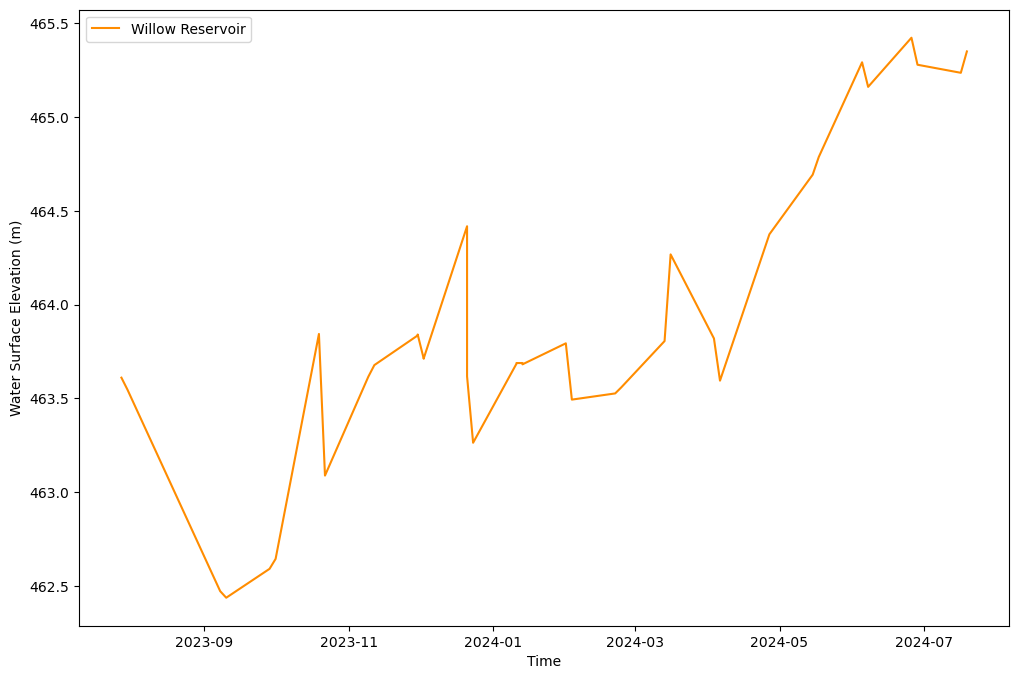

In [20]:
## Plot the timeseries
fig = plt.figure(figsize=(12,8))

plt.plot(lake['time_str'], lake['wse'], label = 'Willow Reservoir', color='darkorange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Water Surface Elevation (m)')